In [314]:
# %load_ext autoreload
# %autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import sys
sys.path.append('../')

/tmp/ipykernel_48950/4126939348.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [315]:
print('test')

test


In [316]:
import math
import argparse
import h5py
import importlib
import numpy as np
import torch
import time
import sys
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
import pickle

from models.vae_flow import *
from models.flow import add_spectral_norm, spectral_norm_power_iteration
from models.shower_flow import compile_HybridTanH_model
from configs import Configs
from utils.plotting import get_projections, get_plots, MAP, offset, layer_bottom_pos, cell_thickness, Xmax, Xmin, Zmax, Zmin
import utils.gen_utils as gen_utils

import models.epicVAE_nflows_kDiffusion as mdls
import models.allCond_epicVAE_nflow_PointDiff as mdls2

import k_diffusion as K


cfg = Configs()

print(cfg.__dict__)

{'name': 'CD_', 'comet_project': 'calo-consistency', 'Acomment': 'long baseline with lat_dim = 0, max_iter 1M, lr=1e-4 fixed, num_steps=18, bs=256, simga_max=80, epoch=2M, EMA', 'log_comet': True, 'model_name': 'epicVAE_nFlow_kDiffusion', 'latent_dim': 0, 'beta_1': 0.0001, 'beta_T': 0.02, 'sched_mode': 'quardatic', 'flexibility': 0.0, 'truncate_std': 2.0, 'latent_flow_depth': 14, 'latent_flow_hidden_dim': 256, 'num_samples': 4, 'features': 4, 'sample_num_points': 2048, 'kl_weight': 0.001, 'residual': False, 'cond_features': 2, 'norm_cond': True, 'kld_min': 1.0, 'use_epic': False, 'epic_layers': 5, 'hid_d': 128, 'sum_scale': 0.001, 'weight_norm': True, 'flow_model': 'PiecewiseRationalQuadraticCouplingTransform', 'flow_transforms': 10, 'flow_layers': 2, 'flow_hidden_dims': 128, 'tails': 'linear', 'tail_bound': 10, 'dataset': 'x36_grid', 'dataset_path': '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/high_granular_grid/train/10-90GeV_x36_grid_regular_524k_float32.hdf5', 'quantized_pos': F

In [317]:
from utils.plotting import get_projections, get_plots, MAP, offset, layer_bottom_pos, cell_thickness, plt_cog
from utils.plotting import cfg as cfg_plt
import utils.plotting as plotting
importlib.reload(plotting)

import numpy as np
import h5py
import matplotlib.pyplot as plt

import joblib

100%|██████████| 30/30 [00:00<00:00, 277.38it/s]


# Shower Flow Model

In [318]:
flow, distribution = compile_HybridTanH_model(num_blocks=10, 
                                        #    num_inputs=32, ### when 'condioning' on additional Esum, Nhits etc add them on as inputs rather than 
                                          #  num_inputs=35, ### when 'condioning' on additional Esum, Nhits etc add them on as inputs rather than 
                                           num_inputs=65, ### adding 30 e layers 
                                           num_cond_inputs=1, device=cfg.device)  # num_cond_inputs

# checkpoint = torch.load('/beegfs/desy/user/akorol/chekpoints/ECFlow/EFlow+CFlow_138.pth')
# checkpoint = torch.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/shower_flow/220706_cog_ShowerFlow_350.pth')
# checkpoint = torch.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/shower_flow/220707_cog_ShowerFlow_500.pth')  # max 730
# checkpoint = torch.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/shower_flow/220713_cog_e_layer_ShowerFlow_best.pth') 
checkpoint = torch.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/shower_flow/220714_cog_e_layer_ShowerFlow_best.pth')   # trained about 350 epochs
flow.load_state_dict(checkpoint['model'])
flow.eval().to(cfg.device)

print('flow model loaded')

flow model loaded


# Diffusion Model

In [319]:
caloclouds = 'cm'   # 'ddpm, 'edm', 'cm'


# caloclouds baseline
if caloclouds == 'ddpm':
    # cfg = Configs()
    kdiffusion=False   # EDM vs DDPM diffusion
    cfg.sched_mode = 'quardatic'
    cfg.num_steps = 100
    cfg.residual = True
    cfg.latent_dim = 256
    cfg.dropout_rate = 0.0
    model = mdls2.AllCond_epicVAE_nFlow_PointDiff(cfg).to(cfg.device)
    checkpoint = torch.load('/beegfs/desy/user/akorol/logs/point-cloud/AllCond_epicVAE_nFlow_PointDiff_100s_MSE_loss_smired_possitions_quardatic2023_04_06__16_34_39/ckpt_0.000000_837000.pt', map_location=torch.device(cfg.device)) # quadratic
    model.load_state_dict(checkpoint['state_dict'])
    coef_real = np.array([ 2.42091454e-09, -2.72191705e-05,  2.95613817e-01,  4.88328360e+01])   # fixed coeff at 0.1 threshold
    coef_fake = np.array([-2.03879741e-06,  4.93529413e-03,  5.11518795e-01,  3.14176987e+02])
    n_splines = None # joblib.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/n_spline/spline_ddpm.joblib')

# caloclouds EDM
elif caloclouds == 'edm':
    # cfg = Configs()
    kdiffusion=True   # EDM vs DDPM diffusion
    cfg.num_steps = 13
    cfg.sampler = 'heun'   # default 'heun'
    cfg.s_churn =  0.0     # stochasticity, default 0.0  (if s_churn more than num_steps, it will be clamped to max value)
    cfg.s_noise = 1.0    # default 1.0   # noise added when s_churn > 0
    cfg.sigma_max = 80.0 #  5.3152e+00  # default 80.0
    cfg.sigma_min = 0.002   # default 0.002
    cfg.rho = 7. # default 7.0
    # # # baseline with lat_dim = 0, max_iter 10M, lr=1e-4 fixed, dropout_rate=0.0, ema_power=2/3 (long training)            USING THIS TRAINING
    cfg.dropout_rate = 0.0
    cfg.latent_dim = 0
    cfg.residual = False
    checkpoint = torch.load(cfg.logdir + '/' + 'kCaloClouds_2023_06_29__23_08_31/ckpt_0.000000_2000000.pt', map_location=torch.device(cfg.device))    # max 5200000
    model = mdls.epicVAE_nFlow_kDiffusion(cfg).to(cfg.device)
    model.load_state_dict(checkpoint['others']['model_ema'])
    coef_real = np.array([ 2.42091454e-09, -2.72191705e-05,  2.95613817e-01,  4.88328360e+01])  # fixed coeff at 0.1 threshold
    coef_fake = np.array([-7.68614180e-07,  2.49613388e-03,  1.00790407e+00,  1.63126644e+02])
    n_splines = None # joblib.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/n_spline/spline_edm.joblib')

# condsistency model
elif caloclouds == 'cm':
    # cfg = Configs()
    kdiffusion=True   # EDM vs DDPM diffusion
    cfg.num_steps = 1
    cfg.sigma_max = 80.0 #  5.3152e+00  # default 80.0
    # long baseline with lat_dim = 0, max_iter 1M, lr=1e-4 fixed, num_steps=18, bs=256, simga_max=80, epoch=2M, EMA
    cfg.dropout_rate = 0.0
    cfg.latent_dim = 0
    cfg.residual = False
    checkpoint = torch.load(cfg.logdir + '/' + 'CD_2023_07_07__16_32_09/ckpt_0.000000_1000000.pt', map_location=torch.device(cfg.device))   # max 1200000
    model = mdls.epicVAE_nFlow_kDiffusion(cfg, distillation = True).to(cfg.device)
    model.load_state_dict(checkpoint['others']['model_ema'])
    coef_real = np.array([ 2.42091454e-09, -2.72191705e-05,  2.95613817e-01,  4.88328360e+01])  # fixed coeff at 0.1 threshold
    coef_fake = np.array([-9.02997505e-07,  2.82747963e-03,  1.01417267e+00,  1.64829018e+02])
    # n_splines = joblib.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/n_spline/spline_cm.joblib')
    n_splines = None # joblib.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/n_spline/spline_cm2.joblib')

else:
    raise ValueError('caloclouds must be one of: ddpm, edm, cm')

model.eval()

print(caloclouds, ' model loaded')

cm  model loaded


In [320]:
importlib.reload(gen_utils)

torch.manual_seed(1234567)
print(' one random torch number: ', torch.rand(1))

n_scaling = True

s_t = time.time()
fake_showers_3 = gen_utils.gen_showers_batch(model, distribution, 90, 90, 2000, bs=16, kdiffusion=kdiffusion, config=cfg, coef_real=coef_real, coef_fake=coef_fake, n_scaling=n_scaling, n_splines=n_splines)
t = time.time() - s_t
print(fake_showers_3.shape)
print(t)
print('time per shower: ', t / 2000)

 one random torch number:  tensor([0.6795])


  0%|          | 0/125 [00:00<?, ?it/s]

100%|██████████| 125/125 [00:02<00:00, 43.10it/s]


(2000, 4, 6000)
3.319277048110962
time per shower:  0.001659638524055481


In [321]:
fake_showers_3[0,0,0]

-40.96491062420391

# Plots

In [322]:
title = r'\textbf{full spectrum}' #  r'\textbf{50 GeV}'
real_label = r'\textsc{Geant4}'
ddpm_label = r'\textsc{CaloClouds}'
edm_label = r'\textsc{CaloClouds II}'
cm_label = r'\textsc{CaloClouds II (CD)}'

In [323]:
path = '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/all_steps/validation/photon-showers_90GeV_A90_Zpos4.slcio.hdf5'
# path = '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/high_granular_grid/validation/50GeV_x36_grid_regular_2k_Z4.hdf5'
# path = '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/high_granular_grid/validation/10-90GeV_x36_grid_regular_float32.hdf5'
# path = '/beegfs/desy/user/akorol/data/calo-clouds/hdf5/all_steps/validation/photon-showers_10-90GeV_A90_Zpos4.slcio.hdf5'
# path = '/beegfs/desy/user/akorol/projects/getting_high/ILDConfig/StandardConfig/production/out/10GeV_x36_grid_regular_2k_Z4_grid_pos_rundom.hdf5'
real_showers = h5py.File(path, 'r')['events'][:]
real_showers[:, -1] = real_showers[:, -1] * 1000   # GeV to MeV
print(real_showers.shape)

# fake_showers = np.load('/beegfs/desy/user/akorol/projects/point-cloud/DM_100s_30GeV_rearanged.npy')
# fake_showers[:, -1] = fake_showers[:, -1] / 1000

fake_showers = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CCbaseline_50GeV_2000.npy')
# fake_showers = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CCbaseline_10-90GeV_40k_wNscaling.npy')
# fake_showers[:, -1] = fake_showers[:, -1] / 1000  # MeV to GeV

# fake_showers_2 = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun18_50GeV_2k.npy')
# fake_showers_2 = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_05_24__14_54_09_heun13_50GeV_2k.npy')
fake_showers_2 = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_06_29__23_08_31_ckpt_0.000000_2000000_heun13_50GeV_2k.npy')
# fake_showers_2 = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/kCaloClouds_2023_06_29__23_08_31_ckpt_0.000000_2000000_10-90GeV_40k_wNscaling.npy')
# fake_showers_2[:, -1] = fake_showers_2[:, -1] / 1000   # MeV to GeV

# fake_showers_2 = np.load('/beegfs/desy/user/akorol/projects/point-cloud/DM_new_100s_50GeV_with_flow_corrections_best_cog.npy')
#fake_showers_2[:, -1] = fake_showers_2[:, -1] / 1000

# fake_showers_3 = np.load('/beegfs/desy/user/akorol/projects/point-cloud/DM_new_100s_90GeV_with_flow_corrections_3.npy')
# fake_showers_3 = np.load('/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/CD_2023_07_07__16_32_09_ckpt_0.000000_1000000_10-90GeV_40k_wNscaling.npy')
# fake_showers_3[:, -1] = fake_showers_3[:, -1] / 1000   # MeV to GeV

(2000, 4, 40000)


In [324]:
real_showers[:2000,-1,:].max(), fake_showers_2[:2000,-1,:].max()

(13.360178, 38.28903579711914)

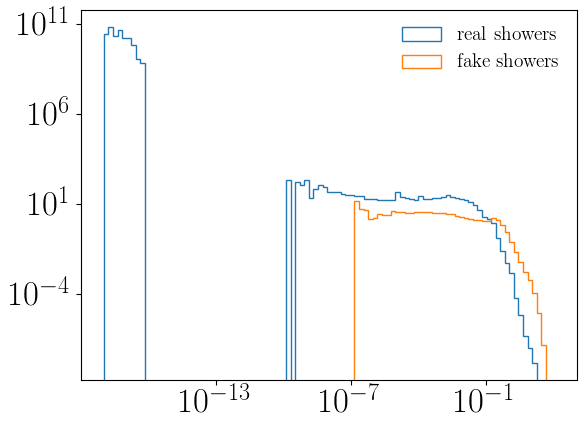

In [325]:
# log bins 
bins = np.logspace(np.log10(real_showers[:,-1,:][real_showers[:,-1,:] != 0.0].min()),np.log10(real_showers[:,-1,:].max()+1e2), 100)
plt.hist(real_showers[:,-1,:][real_showers[:,-1,:] != 0.0], bins = bins, histtype='step', label='real showers', density=True)
plt.hist(fake_showers_2[:,-1,:][fake_showers_2[:,-1,:] != 0.0], bins = bins, histtype='step', label='fake showers', density=True)   
plt.legend(loc='best', fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [326]:
cfg_plt.bins_cog = 50

In [327]:
cog = plotting.get_cog(real_showers, thr=0.0)

cog_2 = plotting.get_cog(fake_showers, thr=0.0)

cog_3 = plotting.get_cog(fake_showers_2, thr=0.0)

cog_4 = plotting.get_cog(fake_showers_3, thr=0.0)

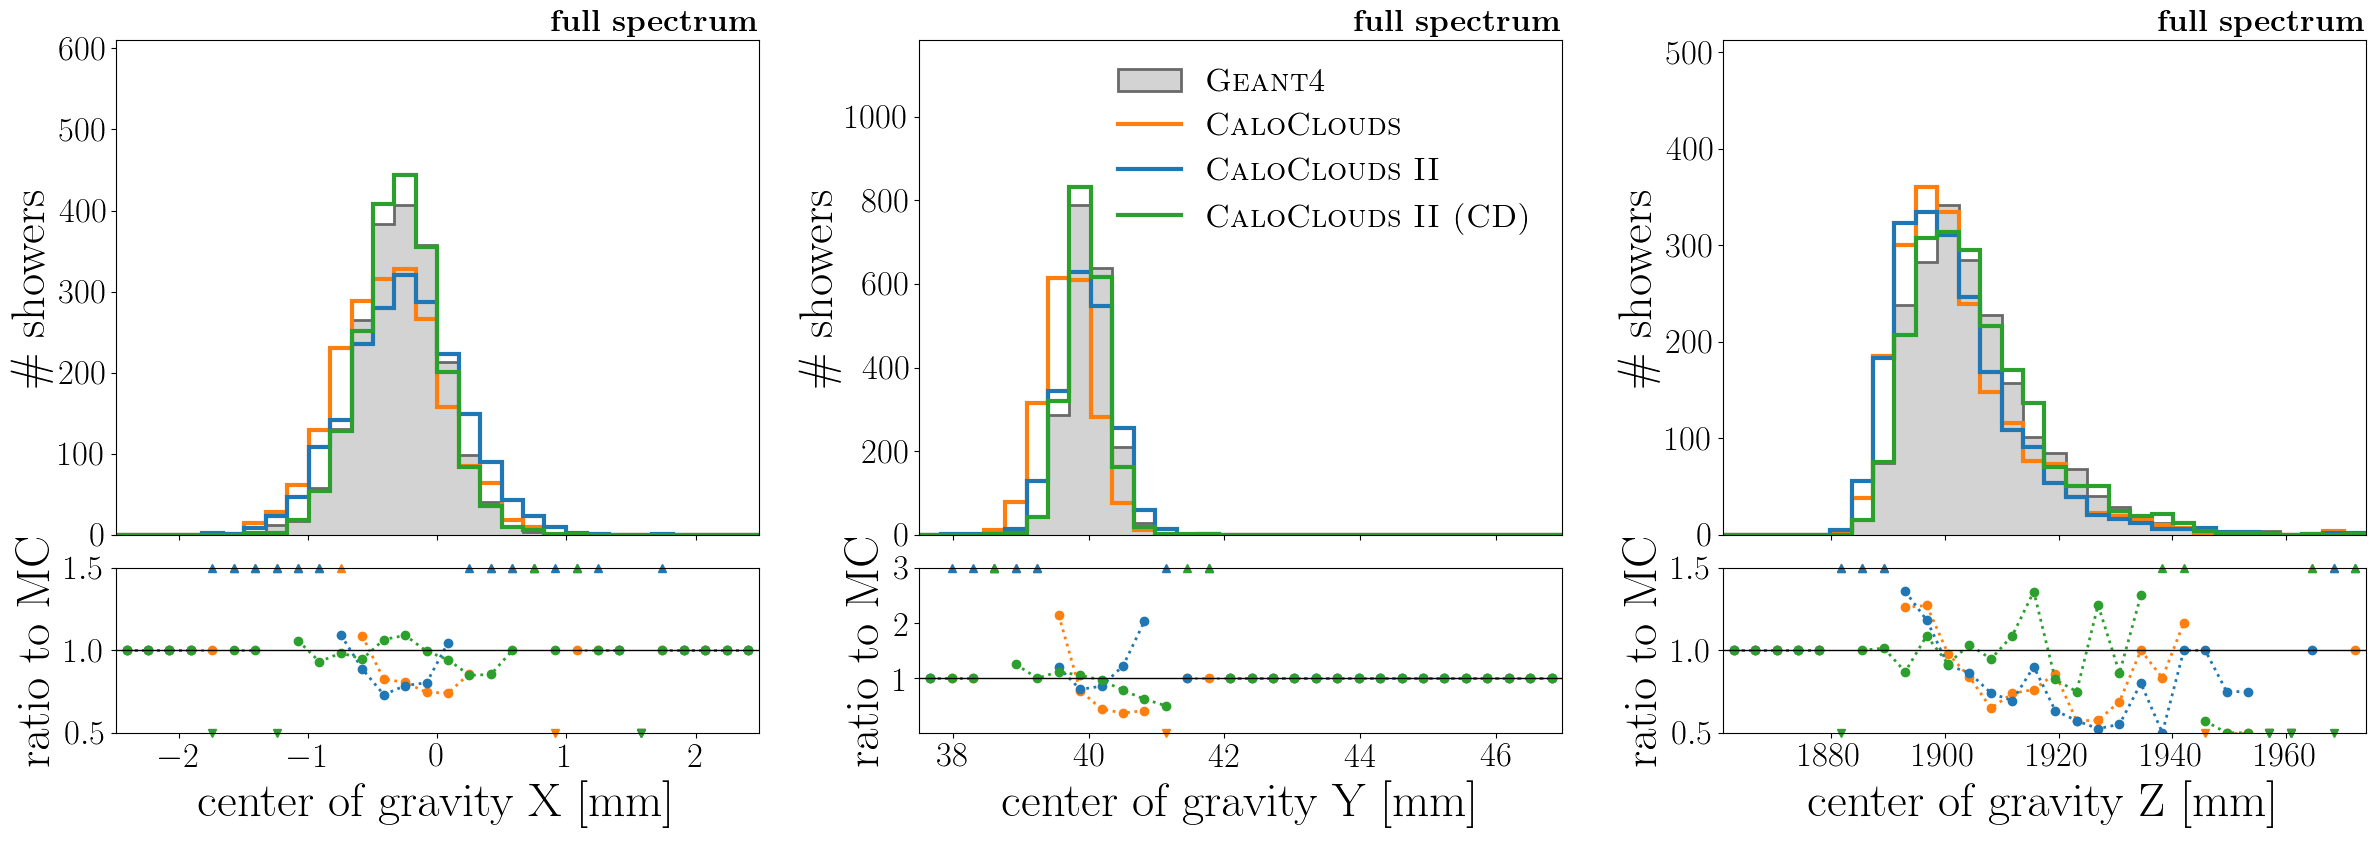

In [328]:
plotting.plt_cog(cog, [cog_2, cog_3, cog_4], [real_label, ddpm_label, edm_label, cm_label], title=title)

In [329]:
cfg.bins_r = 35

# Projections

In [330]:
events, cloud = get_projections(real_showers[0:2000], MAP, layer_bottom_pos, max_num_hits=6000, return_cell_point_cloud=True)
# events_fake, cloud_fake = get_projections(fake_showers, MAP, layer_bottom_pos, max_num_hits=6000, return_cell_point_cloud=True)
# events_fake_2, cloud_fake_2 = get_projections(fake_showers_2, MAP, layer_bottom_pos, max_num_hits=6000, return_cell_point_cloud=True)
events_fake_3, cloud_fake_3 = get_projections(fake_showers_3, MAP, layer_bottom_pos, max_num_hits=6000, return_cell_point_cloud=True)

100%|██████████| 2000/2000 [00:03<00:00, 542.28it/s]


In [331]:
cloud[:,-1,:].max(), cloud_fake_3[:,-1,:].max()

(96.64256601948, 106.49187555909157)

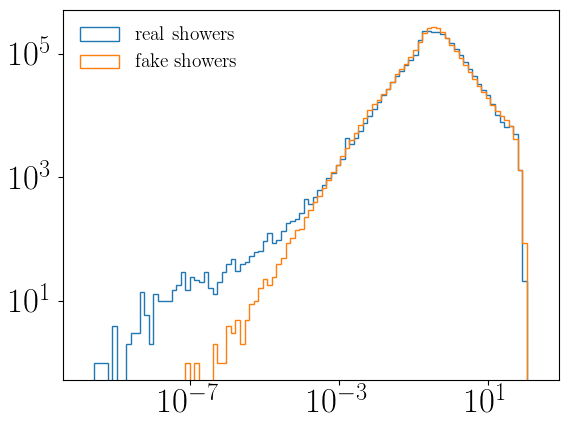

In [332]:
# log bins 
bins = np.logspace(np.log10(cloud[:,-1,:][cloud[:,-1,:] != 0.0].min()),np.log10(cloud[:,-1,:].max()+1e2), 100)
plt.hist(cloud[:,-1,:][cloud[:,-1,:] != 0.0], bins = bins, histtype='step', label='real showers', density=False)
plt.hist(cloud_fake_3[:,-1,:][cloud_fake_3[:,-1,:] != 0.0], bins = bins, histtype='step', label='fake showers', density=False)   
plt.legend(loc='best', fontsize=14)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [333]:
importlib.reload(plotting)

n = 2000

c_cog = plotting.get_cog(cloud[:n])
print('1')
c_cog_2 = plotting.get_cog(cloud_fake[:n])
print('2')
c_cog_3 = plotting.get_cog(cloud_fake_2[:n])
print('3')
c_cog_4 = plotting.get_cog(cloud_fake_3[:n])
print('4')
c_cog_real = c_cog
c_cog_fake = [c_cog_2, c_cog_3, c_cog_4]

100%|██████████| 30/30 [00:00<00:00, 273.01it/s]


1
2
3
4


100%|██████████| 30/30 [00:00<00:00, 271.82it/s]

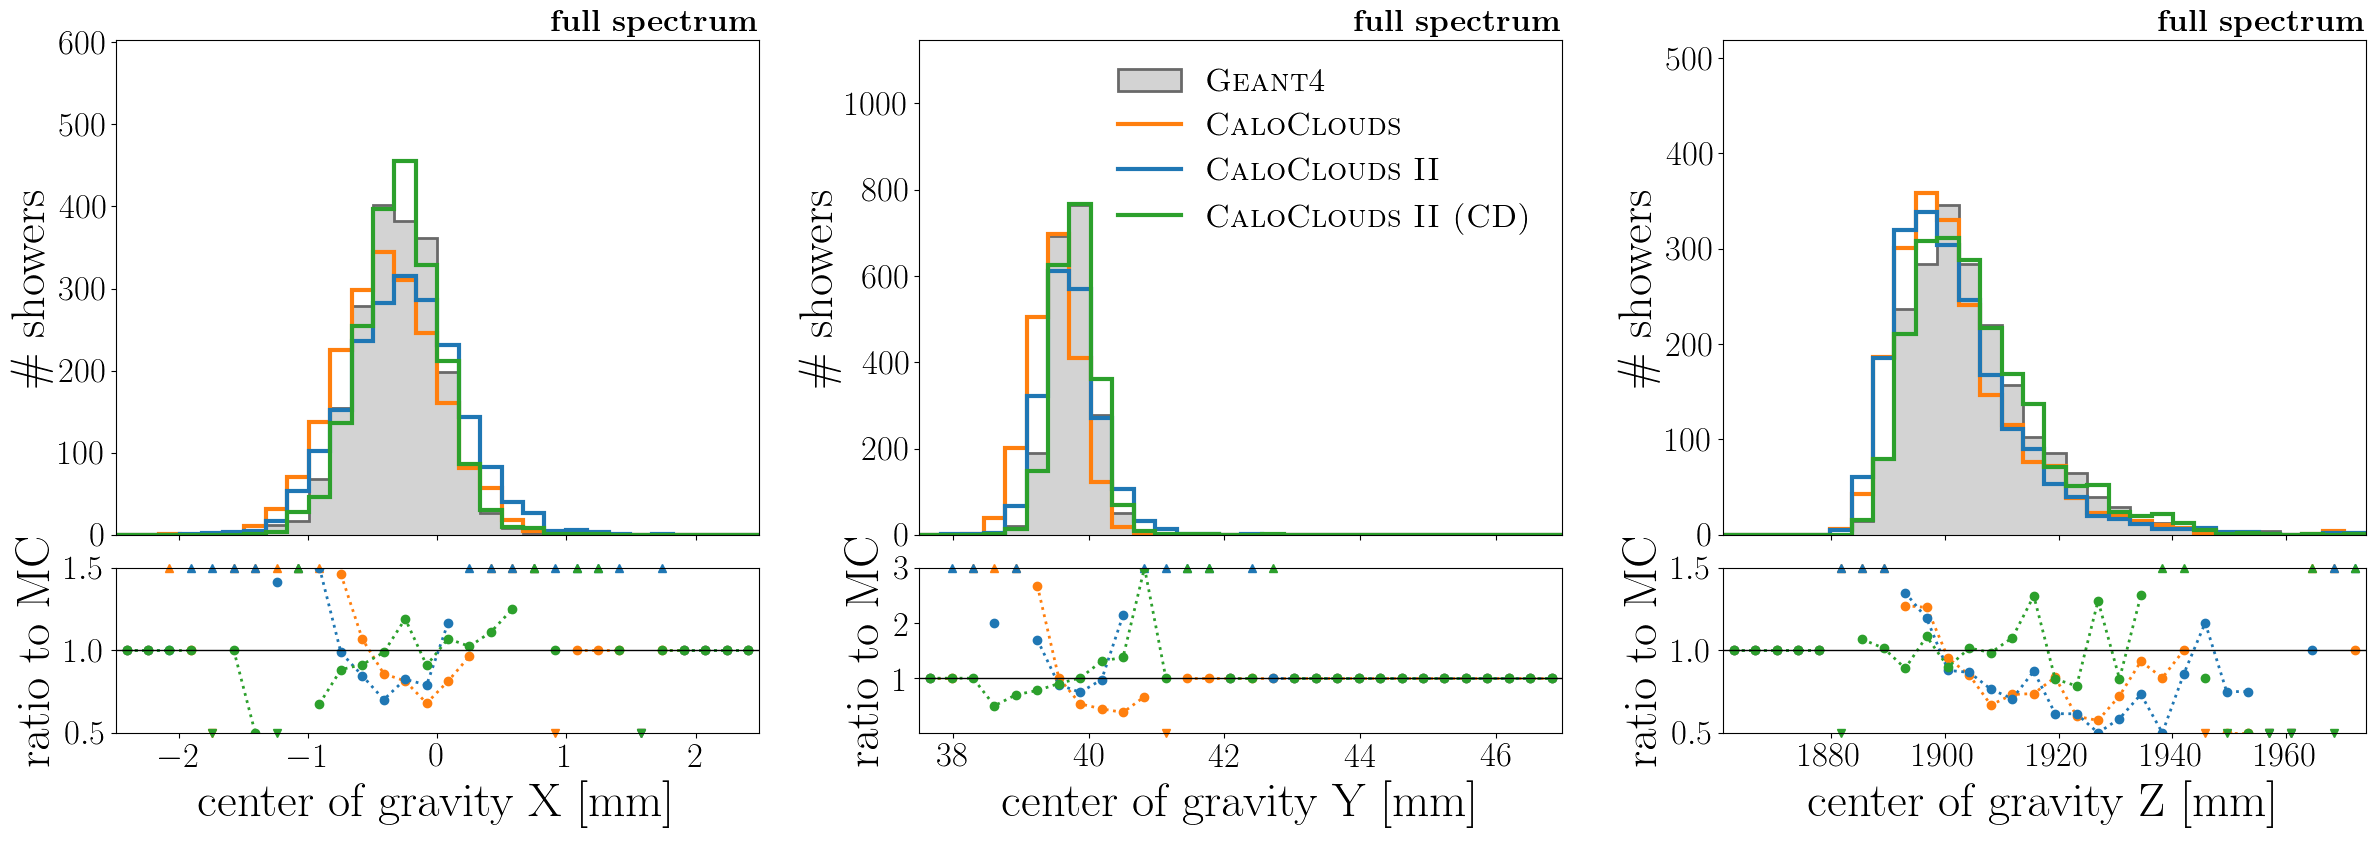

In [334]:
importlib.reload(plotting)
plotting.plt_cog(c_cog_real, c_cog_fake, [real_label, ddpm_label, edm_label, cm_label], title=title)

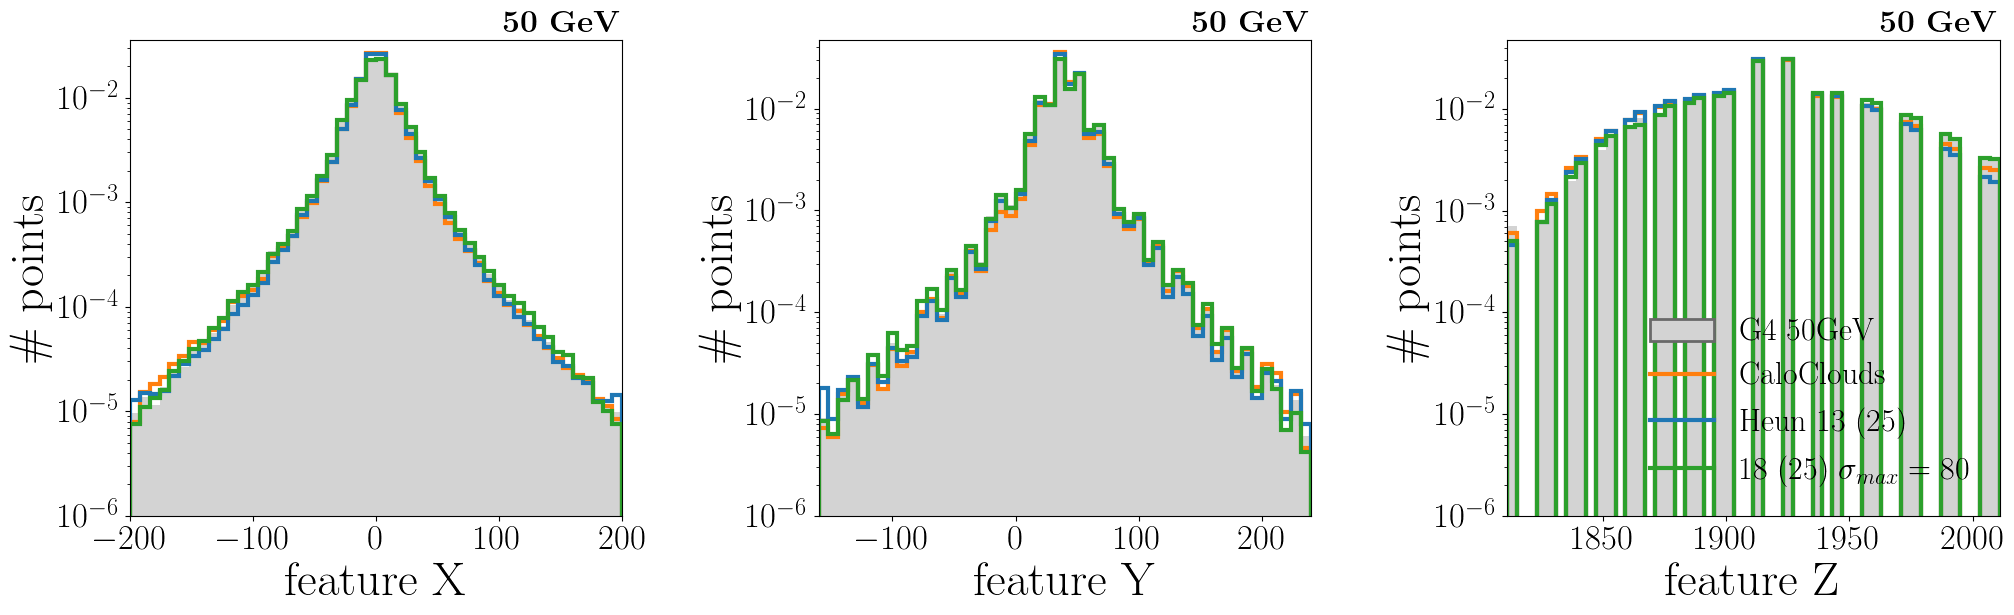

In [335]:
# plotting.plt_feats(cloud, [cloud_fake, cloud_fake_2, cloud_fake_3], ['G4 50GeV', 'CaloClouds', 'Heun 13 (25)', r'13 (25) $\sigma_{max}=80$'], title=r'\textbf{50 GeV}', density=False)
# plotting.plt_feats(cloud, [cloud_fake, cloud_fake_2, cloud_fake_3], ['G4 50GeV', 'CaloClouds', 'Heun 13 (25)', r'13 (25) $\sigma_{max}=80$'], title=r'\textbf{50 GeV}', density=True)
plotting.plt_feats(cloud, [cloud_fake, cloud_fake_2, cloud_fake_3], ['G4 50GeV', 'CaloClouds', 'Heun 13 (25)', r'18 (25) $\sigma_{max}=80$'], title=r'\textbf{50 GeV}', scale='log', density=True)

In [336]:
# get_plots(events, [events_fake, events_fake_2],
importlib.reload(plotting)
# plotting.get_plots(events, [events_fake, events_fake_2, events_fake_3],
#             labels = [real_label, ddpm_label, edm_label, cm_label],
#             title=title,
#          )
real_list, fakes_list = plotting.get_observables_for_plotting(events, [events_fake, events_fake_2, events_fake_3])

  1%|▏         | 29/2000 [00:00<00:07, 281.37it/s]

100%|██████████| 2000/2000 [00:05<00:00, 348.18it/s]


In [337]:
# occ mean

real_list[1].mean(), fakes_list[1][2].mean()

(1127.541, 1154.87)

100%|██████████| 30/30 [00:00<00:00, 273.75it/s]

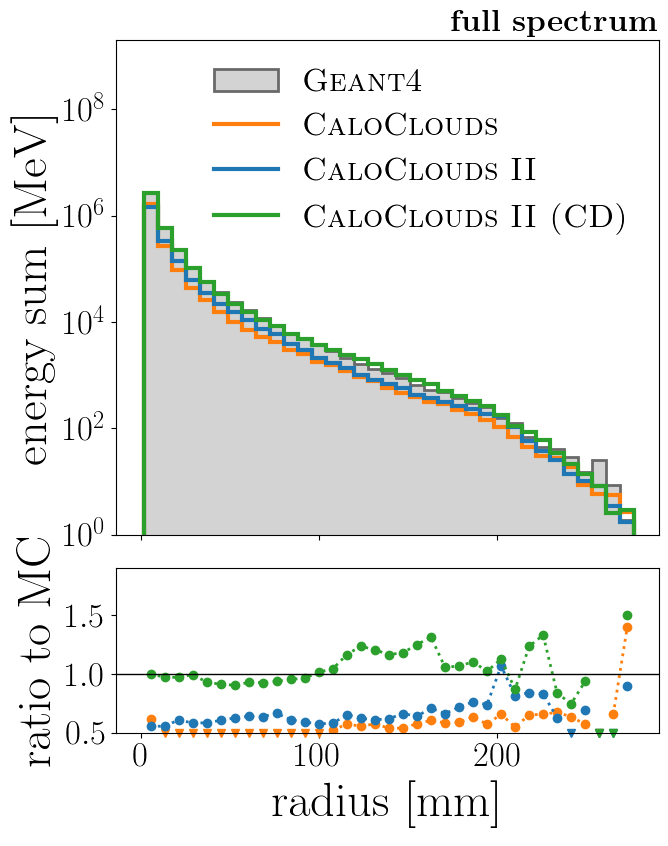

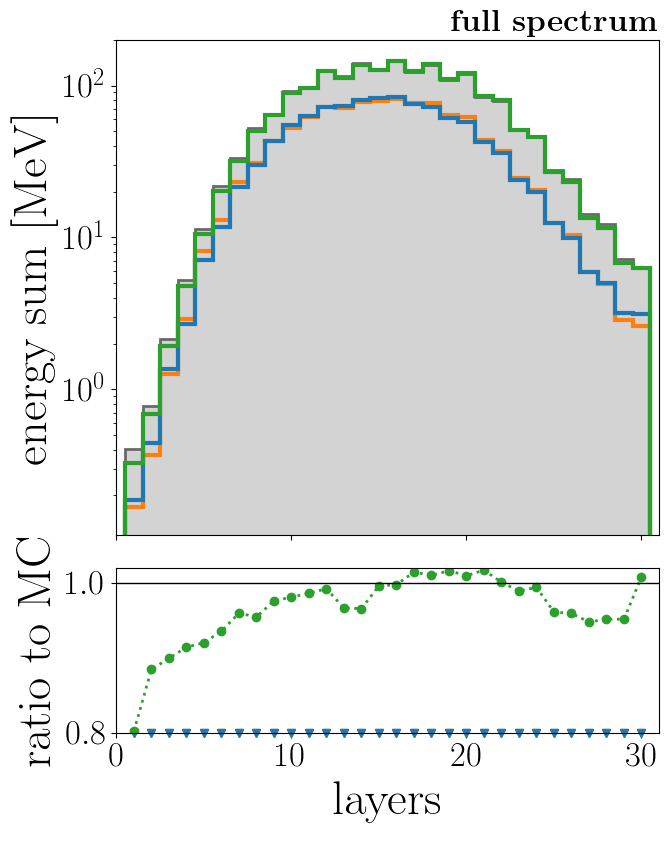

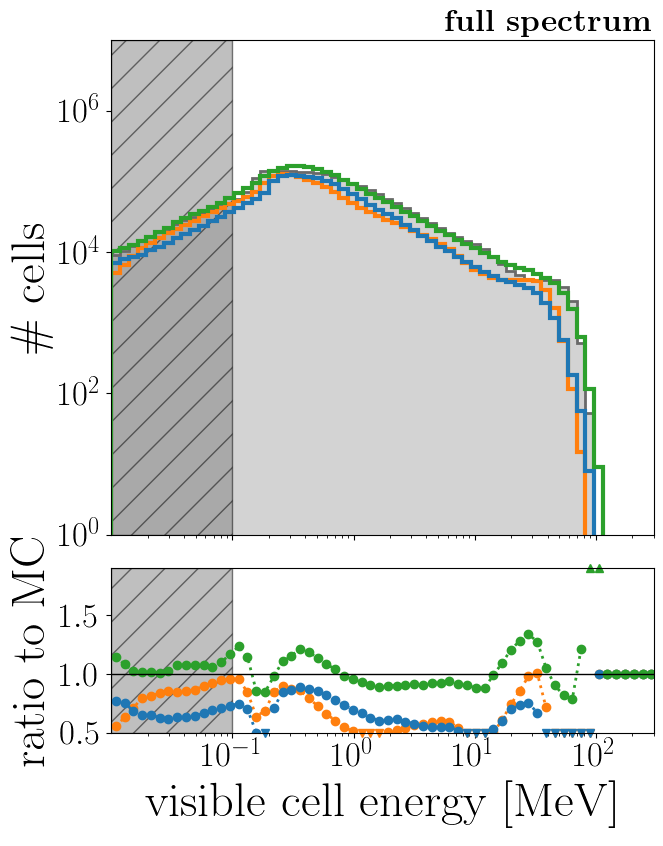

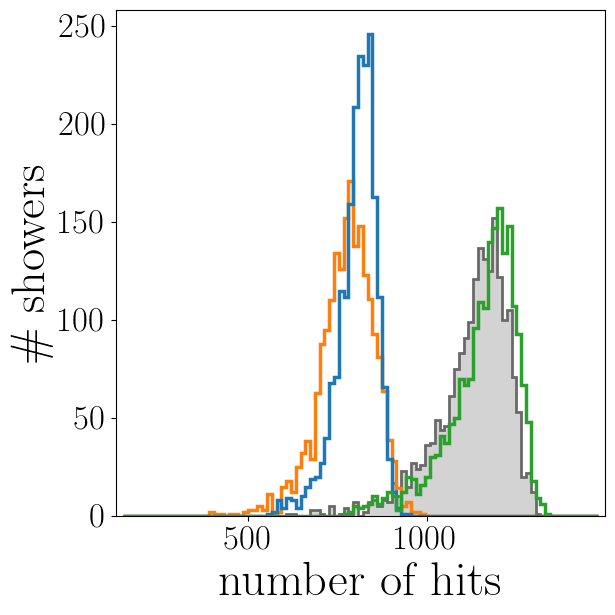

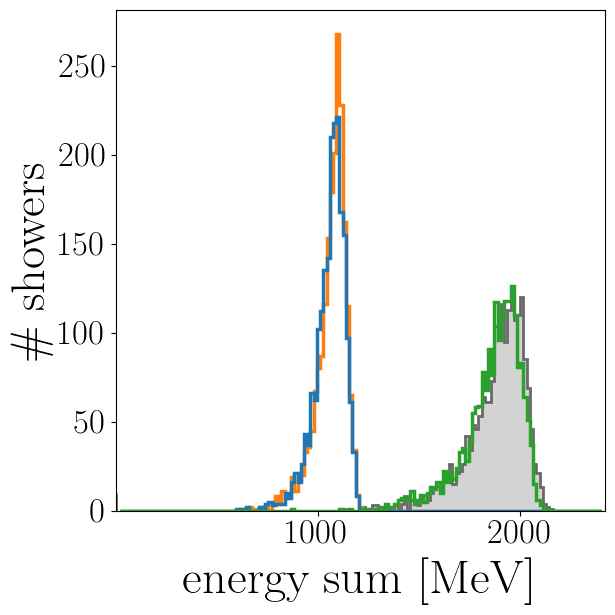

In [338]:
importlib.reload(plotting)

plotting.get_plots_from_observables(real_list, fakes_list, labels = [real_label, ddpm_label, edm_label, cm_label], title=title)

In [339]:
# importlib.reload(plotting)
# plotting.get_plots(events, [events_fake, events_fake_2, events_fake_3],
#             labels = [real_label, ddpm_label, edm_label, cm_label],
#             title=title,
#          )

In [340]:
fake_showers_3.shape, fake_showers_3[0,-1,1]

((2000, 4, 6000), 0.07683335244655609)

In [341]:
out_path = '/beegfs/desy/user/buhmae/6_PointCloudDiffusion/output/singleE/'
f = out_path + '{}-{}GeV_{}_{}_seed{}.npy'.format(str(50), str(50), str(2000), 'cm', str(12345))
fake_showers_loaded = np.load(f)

In [342]:
fake_showers_loaded.shape, fake_showers_loaded[0,-1,1]

((2000, 4, 6000), 0.10595927387475967)